In [1]:
machine = 'mac'
machine = 'magny'

In [12]:
from galpy.potential import MiyamotoNagaiPotential, NFWPotential, HernquistPotential
from galpy.actionAngle import estimateDeltaStaeckel, actionAngleStaeckel

from areposnap.gadget import gadget_readsnap
from areposnap.gadget_subfind import load_subfind

from auriga_basics import *
from auriga_functions import *

import numpy as np
from IPython.display import Image, display

import corner

import datetime

%matplotlib inline

In [3]:
if machine == 'magny':
    filedir = "/home/extmilan/masterthesis/files/"
elif machine == 'mac':
    filedir = "/Users/smilanov/Documents/masterthesis/auriga_files/files/"
else:
    raise NotADirectoryError

In [4]:
#### path = /hits/universe/GigaGalaxy/level4_MHD/halo_24/output/*
level = 4
if machine == 'magny':
    basedir = "/hits/universe/GigaGalaxy/level4_MHD/"
elif machine == 'mac': 
    basedir = "/Users/smilanov/Desktop/Auriga/level4/"
j = 0
for halo_number in [24]:  # range(1, 31):
    halodir = basedir+"halo_{0}/".format(halo_number)
    snappath = halodir+"output/"
    for snapnr in range(127,128,1):
        print("level   : {0}".format(level))
        print("halo    : {0}".format(halo_number))
        print("snapnr  : {0}".format(snapnr))
        print("basedir : {0}".format(basedir))
        print("halodir : {0}".format(halodir))
        print("snappath: {0}\n".format(snappath))
        s, sf = eat_snap_and_fof(level, halo_number, snapnr, snappath, loadonlytype=[0,1,2,3,4,5], 
            haloid=0, galradfac=0.1, verbose=True) 

        # Clean negative and zero values of gmet to avoid RuntimeErrors
        # later on (e.g. dividing by zero)
        s.data['gmet'] = np.maximum( s.data['gmet'], 1e-40 )
     

level   : 4
halo    : 24
snapnr  : 127
basedir : /hits/universe/GigaGalaxy/level4_MHD/
halodir : /hits/universe/GigaGalaxy/level4_MHD/halo_24/
snappath: /hits/universe/GigaGalaxy/level4_MHD/halo_24/output/

[ 34.42281723  33.16259384  37.29567337]
Found 1783163 stars.
Rotated pos.
Rotated bfld.
Rotated vel.

galrad  : 0.02408556640148163
redshift: 2.220446049250313e-16
time    : 0.9999999999999998
center  : [ 0.  0.  0.]



In [6]:
#_____reference values for galpy_____
_REFR0_kpc = 8.

#_____function that sets-up galpy potential_____
def setup_galpy_potential(a_MND_kpc,b_MND_kpc,a_NFWH_kpc,a_HB_kpc,n_MND,n_NFWH,n_HB):
    
    #test input:
    if (a_MND_kpc <= 0.) or (b_MND_kpc <= 0.) or (a_NFWH_kpc <= 0.) or (a_HB_kpc <= 0.) \
       or (n_MND <= 0.) or (n_NFWH <= 0.) or (n_HB <= 0.) or (n_MND >= 1.) or (n_NFWH >= 1.) or (n_HB >= 1.):
        raise ValueError('Error in setup_galpy_potential: '+\
                         'The input parameters for the scaling profiles do not correspond to a physical potential.')
    if np.fabs(n_MND + n_NFWH + n_HB - 1.) > 1e-7:
        raise ValueError('Error in setup_galpy_potential: '+\
                         'The sum of the normalization does not add up to 1.')
        
    #trafo to galpy units:
    a_MND  = a_MND_kpc/_REFR0_kpc
    b_MND  = b_MND_kpc/_REFR0_kpc
    a_NFWH = a_NFWH_kpc/_REFR0_kpc
    a_HB   = a_HB_kpc/_REFR0_kpc
    
    #setup potential:
    disk = MiyamotoNagaiPotential(
                a=a_MND,
                b=b_MND,
                normalize=n_MND)
    halo = NFWPotential(
                a=a_NFWH,
                normalize=n_NFWH)
    bulge = HernquistPotential(
                a=a_HB,
                normalize=n_HB)
    return [disk,halo,bulge]
    #return [disk,halo]

In [7]:
# read in ID lists generated in notebook 2dwarf
ids_notused = np.loadtxt(filedir + 'surviving_ids_snapshot_67_sh_1.txt', dtype = 'int') # 2648 particles 
ids = np.loadtxt(filedir + 'surviving_ids_zsignchange_snapshot_67_sh_1.txt', dtype = 'int') # 93 particles

id_list = [ids, ids_notused]

Start: 17:32:46.642899
Start diff_ev : 17:32:46.650760
Start list 1 in diff_ev : 17:32:46.653113


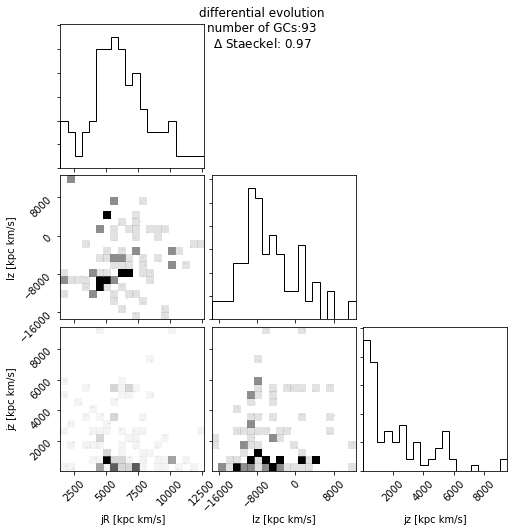

Start list 2 in diff_ev : 17:34:15.939813


KeyboardInterrupt: 

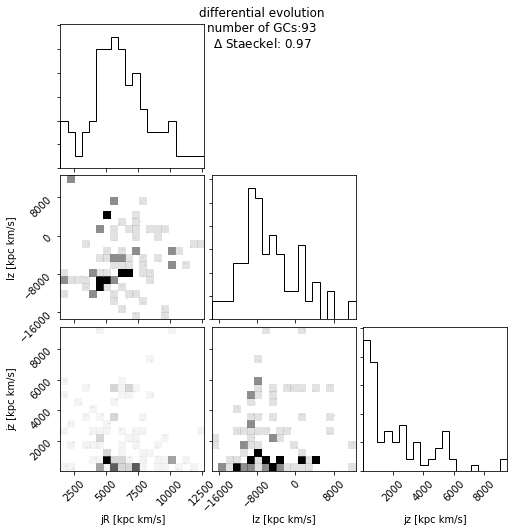

In [15]:
# read in the different results of the different fitting routines of notebook 1pot
print('Start:',datetime.datetime.now().time())
pot_fit_routines = ['diff_ev', 'emcee1', 'emcee2']
for routine in pot_fit_routines:
    print('Start', routine, ':',datetime.datetime.now().time())
    if routine == 'diff_ev':
        v0_kms, a_MND_kpc, b_MND_kpc, a_NFWH_kpc, a_HB_kpc, n_MND, n_NFWH, n_HB = np.loadtxt(filedir + 'pot_res_diff_ev.txt')
        title = 'differential evolution'
    elif routine == 'emcee1':
        v0_kms, a_MND_kpc, b_MND_kpc, a_NFWH_kpc, a_HB_kpc, n_MND, n_NFWH, n_HB = np.loadtxt(filedir + 'pot_res_emcee1.txt')
        title = '1st MCMC'
    elif routine == 'emcee2':
        v0_kms, a_MND_kpc, b_MND_kpc, a_NFWH_kpc, a_HB_kpc, n_MND, n_NFWH, n_HB = np.loadtxt(filedir + 'pot_res_emcee2.txt')
        title = '2nd MCMC'
    else:
        raise FileNotFoundError  
        
    _REFV0_kms = v0_kms
        
    pot_galpy = setup_galpy_potential(a_MND_kpc, b_MND_kpc, a_NFWH_kpc, a_HB_kpc, n_MND, n_NFWH, n_HB)
    j = 1
    for ID in id_list:    
        print('Start list', j, 'in', routine, ':',datetime.datetime.now().time())
        j += 1
        gcmask = np.isin(s.id, ID)

        # get position and velocities of all selected GCs & convert to galpy units
        (R_kpc, phi_rad, z_kpc), (vR_kms, vphi_kms, vz_kms) = get_cylindrical_vectors(s, sf, gcmask)
        R_galpy, vR_galpy, vT_galpy, z_galpy, vz_galpy = R_kpc / _REFR0_kpc, vR_kms / _REFV0_kms, vphi_kms / _REFV0_kms, z_kpc / _REFR0_kpc, vz_kms / _REFV0_kms

        # estimate Delta of the Staeckel potential
        delta = estimateDeltaStaeckel(pot_galpy, R_galpy, z_galpy)
        
        # set up the actionAngleStaeckel object
        aAS = actionAngleStaeckel(
                pot   = pot_galpy,  # potential
                delta = delta,      # focal length of confocal coordinate system
                c     = True        # use C code (for speed)
                )
        # calculate actions (in galpy units) & convert them to physical units
        jR_galpy, lz_galpy, jz_galpy = aAS(R_galpy ,vR_galpy ,vT_galpy ,z_galpy ,vz_galpy )
        jR_kpckms, lz_kpckms, jz_kpckms = jR_galpy * _REFR0_kpc * _REFV0_kms, lz_galpy * _REFR0_kpc * _REFV0_kms, jz_galpy * _REFR0_kpc * _REFV0_kms
 
        # prepare data for plotting and create corner plot
        data = np.vstack([jR_kpckms, lz_kpckms, jz_kpckms])
        labels = ['jR [kpc km/s]', 'lz [kpc km/s]', 'jz [kpc km/s]']
        figure = corner.corner(data.transpose(), labels = labels, plot_contours = 0)
        figure.suptitle(title + '\nnumber of GCs: ' + str(len(R_kpc)) + '\n$\Delta$ Staeckel: ' + "{:2.2f}".format(delta));

        display(figure)
print('End:',datetime.datetime.now().time())
